# EXOGENUOUS PROCESSES IN DOLO: AR(1) example

The aim of this notebook is to visualize the use of different types of discretization procedures to solve a non-linear model which driving process is given by an AR(1) process. We show how to discretize an AR(1) using a Markov Chain (MC), a General Discretized Process (GDP), and a Bounded General Discretized Process (BGDP) as a subtype of GDP. Conditional on the discretization approach, we present the results of the corresponding method solutions and simulations.

As an example we are going to consider a standard rbc model :



In [1]:
path = Pkg.dir("Dolo")
import Dolo
using AxisArrays

In [2]:
filename = ("https://raw.githubusercontent.com/EconForge/dolo_models/master/RBCS/rbc_ar1.yaml");

In [3]:
model = Dolo.yaml_import(filename)

Model 


MethodError: MethodError: no method matching sanitize(::Expr, ::Dolo.Model{Symbol("##336")})[0m
Closest candidates are:
  sanitize(::Expr, [1m[31m::Array{Symbol,1}[0m) at /home/anastasia/.julia/v0.5/Dolo/src/printing.jl:14
  sanitize(::Any, [1m[31m::Array{Symbol,1}[0m) at /home/anastasia/.julia/v0.5/Dolo/src/printing.jl:3
  sanitize(::Any, [1m[31m::Dolo.SModel{ID}[0m) at /home/anastasia/.julia/v0.5/Dolo/src/printing.jl:32[0m

### Caracteristics of an AR(1) process used in our example:

In [4]:
#The process has a mean : 
print(model.exogenous.mu)
# and a steandard deviation: 
print(sqrt(model.exogenous.Sigma))
# and persistence parameter:
print(sqrt(model.exogenous.R))

[0.0][0.016][0.894427]

So here we are dealing with an AR(1) process of the form: $m_t= 0.89 y_{t-1}+ \epsilon_t$ ans $\epsilon_t \sim \mathcal{N}(\mu = 0, \sigma = 0.016)$

Let's simulate the process

In [7]:
# Choose number of simulations, N, and number of simulated periods, T.
N=50
T = 1000

# simulate the process 
simAR = Dolo.simulate(model.exogenous,N,T);

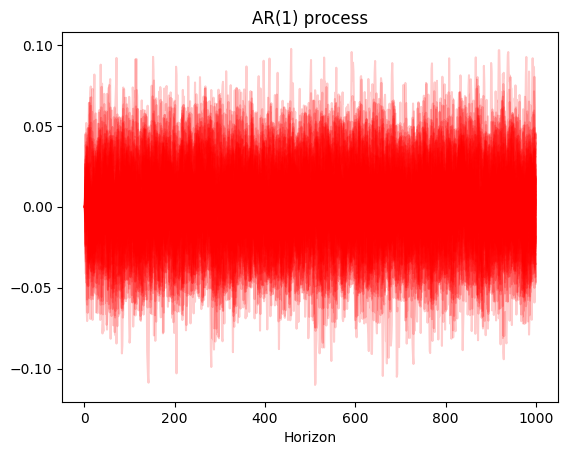

In [8]:
# Plot the simulated process

import PyPlot
plt = PyPlot;

hor= linspace(1, T, T)
for i in 1:size(simAR,2)
    plt.plot(hor, vec(simAR[:,i,:]), color="red", alpha = .2)
end

plt.xlabel("Horizon");
plt.title("AR(1) process");

# Discretizing AR(1)

### Markov Chain Process

Let's discretize the given AR(1) process into a Markov Chain with N states

In [9]:
mc_ar = Dolo.discretize(Dolo.MarkovChain, model.exogenous; N=5)

Dolo.DiscreteMarkovProcess(Dolo.UnstructuredGrid
,[0.6561 0.2916 … 0.0036 0.0001; 0.0729 0.6804 … 0.0244 0.0009; … ; 0.0009 0.0244 … 0.6804 0.0729; 0.0001 0.0036 … 0.2916 0.6561],[-0.0533333; -0.0266667; … ; 0.0266667; 0.0533333])

This gives us five states mc.values together with transition probability matrix

In [10]:
print(mc_ar.values)

[-0.0533333; -0.0266667; 0.0; 0.0266667; 0.0533333]

In [11]:
mc_ar.transitions

5×5 Array{Float64,2}:
 0.6561  0.2916  0.0486  0.0036  0.0001
 0.0729  0.6804  0.2214  0.0244  0.0009
 0.0081  0.1476  0.6886  0.1476  0.0081
 0.0009  0.0244  0.2214  0.6804  0.0729
 0.0001  0.0036  0.0486  0.2916  0.6561

Let us simulate the discretize version of the process and compare it with the initial one.

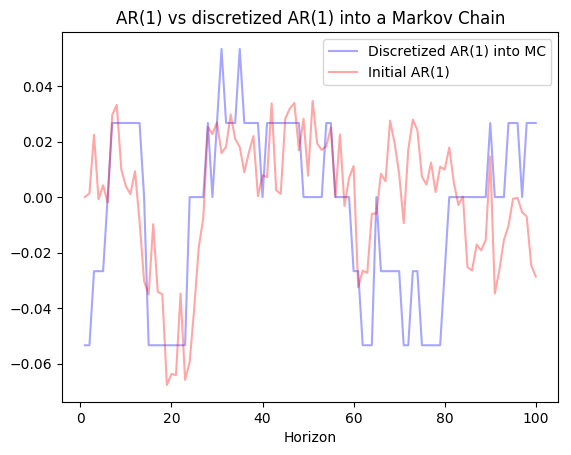

In [13]:
N= 1 # number  of simulations
T=100 # periods of simulation
hor= linspace(1, T, T)

fig = plt.figure("AR(1) vs discretized AR(1) (Markov Chain)")

sim_mc= Dolo.simulate(mc_ar, N, T, 1; return_indexes=false)
simAR = Dolo.simulate(model.exogenous,N,T);
plt.plot(hor, sim_mc, color="blue", alpha = .35, label ="Discretized AR(1) into MC")
plt.plot(hor, simAR[1,1,:], color="red", alpha = .35, label = "Initial AR(1)")
plt.legend()
plt.xlabel("Horizon");
plt.title("AR(1) vs discretized AR(1) into a Markov Chain");

### General Discretized Process

Then, a General Discretized Process (GDP) is obtained in the following way:


1.  Compute an ergodic distribution of $m_t$. What we need is a standard deviation,  $\sigma$, of its ergodic distribution. It can be computed using {\cb{solve\_discrete\_lyapunov}} from QuantEcon lybrary, which solve the following equasion: $\rho \mathcal{Y} \rho'- \mathcal{Y} + \Sigma =0$, where $\Sigma = \sigma \sigma'$ and $\mathcal{Y}$ is a varience-covarience matrix of ergodic distribution.

2. Truncate $n$ standard deviations.
3. Find $\mathcal{K}$ nodes of today, $\lbrace m_k \rbrace _{k \in [1:\mathcal{K}]}$. This step is implemented using a Dolo function Dolo.CartesianGrid which takes ($-n*\sigma$,$n*\sigma$, number of states).

4. Discretize innovation process $\epsilon_t$ using quadrature or curbature rules (for example one could use qnwnorm function from QuantEcon). Obtain $\mathcal{L}$ grid nodes of innovations,
$\mathcal{K}$ nodes of today, $\lbrace \epsilon_l \rbrace _{l \in [1:\mathcal{L}]}$  , together with a weith for each node $w_{l}$.

5. Combine the nodes $\vec{m}_t$ and $\vec{\epsilon}_t$ to obtain integration nodes of tomorrow: $M_{k,l}=\rho m_k +\epsilon_l $

$
\begin{cases}
M_{k,l}=\rho m_k +\epsilon_l\\
w_{kl} = w_{l}
\end{cases}
$

In the example that follows, we choose $\mathcal{K}=5$, $\mathcal{L}=2$ $\forall k$ in $\mathcal{K}$ and $n$ is by default 2


In [14]:
n_states=[5]; # K
n_integration=[2]; #L
gdp_ar = Dolo.discretize(model.exogenous, n_states, n_integration)

## Solving a model using different discretization techniques

In our example we are using time_iteration method to solve the model. By default, solution is based on GDP discretization, hence the driving process does not need to be specified as an input of the ${\color{blue}{Dolo.time\_iteration}}$ function. On the other hand, when one prefers the initial AR(1) process to be approximated by a Markov Chain it should be specified in the inputs of the solution function. 

In [17]:
# Markov Chain
@time dr_mc = Dolo.time_iteration(model, mc_ar, verbose=false, maxit=10000, details=false);

  1.255636 seconds (6.79 M allocations: 653.641 MB, 7.90% gc time)


In [18]:
# General Descretized Process
@time dr_gdp = Dolo.time_iteration(model, verbose=false, maxit=10000, details=false);

  4.479524 seconds (14.22 M allocations: 1.077 GB, 4.48% gc time)


Let's compare the two solutions by plotting them. To plot a decision rule we are using a ${\color{blue}{Dolo.tabulate}}$ function which simulates the variables of the model for a gived (provided) state. In the sake of comparability analysis, we are plotting the three decision corresponding to the MC case: the first and the last correspond to the low and high productivity states respectively, and the middle case shall be the closes to the GDP case. 

In [19]:
# Simulating a decision rule for GDP-discretization case
df_gdp = Dolo.tabulate(model, dr_gdp, :k)

2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:z,:k,:n,:i]
    :k, [4.67749,4.77198,4.86648,4.96097,5.05547,5.14996,5.24446,5.33895,5.43345,5.52794  …  13.182,13.2765,13.371,13.4655,13.56,13.6545,13.749,13.8435,13.938,14.0325]
And data, a 4×100 Array{Float64,2}:
 0.0       0.0       0.0       0.0       …   0.0       0.0        0.0     
 4.67749   4.77198   4.86648   4.96097      13.8435   13.938     14.0325  
 0.437888  0.434784  0.431684  0.42859       0.27686   0.275975   0.275092
 0.282351  0.281777  0.281174  0.280514      0.18825   0.187294   0.186334

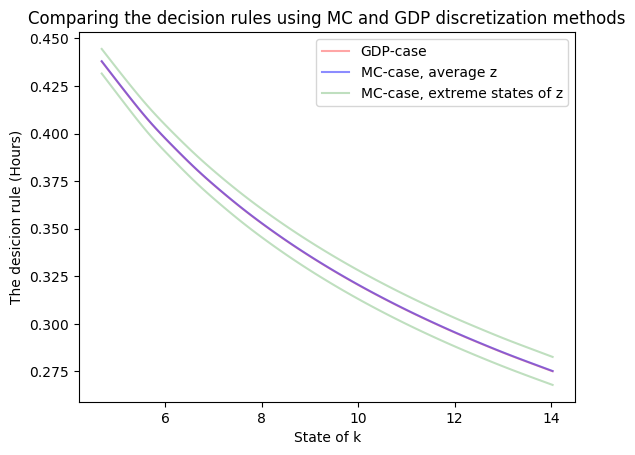

In [23]:
# Simulating a decision rule for MC-discretization case
s0 = model.calibration[:states]
df_mc1 = Dolo.tabulate(model, dr_mc, :k, s0, 1)
df_mc3 = Dolo.tabulate(model, dr_mc, :k, s0, 3)
df_mc5 = Dolo.tabulate(model, dr_mc, :k, s0, 5)

hor= linspace(1, T, T)

fig = plt.figure("Comparing")

plt.plot(df_gdp[:k], df_gdp[Axis{:V}(:n)], color="red", alpha = .35, label="GDP-case")
plt.plot(df_mc3[:k], df_mc3[Axis{:V}(:n)], color="blue", alpha = .45, label="MC-case, average z")
plt.plot(df_mc1[:k], df_mc1[Axis{:V}(:n)], color="green", alpha = .25, label="MC-case, extreme states of z")
plt.plot(df_mc5[:k], df_mc5[Axis{:V}(:n)], color="green", alpha = .25)
plt.xlabel("State of k");
plt.legend()
plt.ylabel("The desicion rule (Hours)");
plt.title("Comparing the decision rules using MC and GDP discretization methods");

# Simulations

First, we simulate the model solved using MC-discretization method and the exogenous driving process is initiated from the MC.

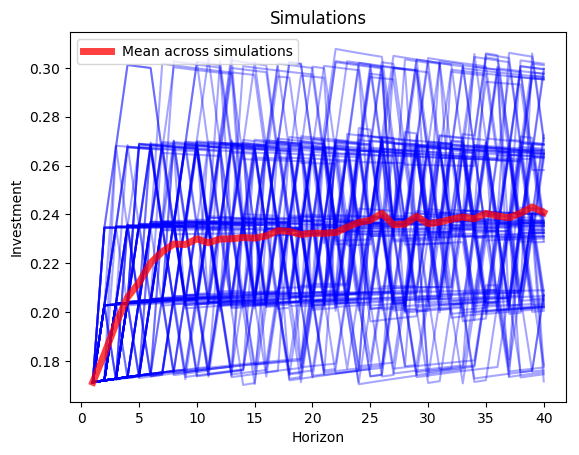

In [32]:
sim_armc = Dolo.simulate(model, dr_mc, mc_ar; N=100)

plt.title("Simulations");
plt.xlabel("Horizon");
plt.ylabel("Investment");
hor = linspace(1, sim_armc[Axis{:T}][end], sim_armc[Axis{:T}][end])
for i in 1:sim_armc[Axis{:N}][end]
   plt.plot(hor, sim_armc[Axis{:N}(i), Axis{:V}(:i)], color="blue", alpha = .35)
end

sim_mean = sum(sim_armc[Axis{:N}(i), Axis{:V}(:i)] for i in 1:sim_armc[Axis{:N}][end] )/sim_armc[Axis{:N}][end]

plt.plot(hor, sim_mean, color="red", alpha = 0.75, linewidth=5, label = "Mean across simulations")
plt.legend();

### Now, let's compare the simulations using an initial driving process AR(1) and dr(m,s) and using MC as a driving process with dr(i,s)

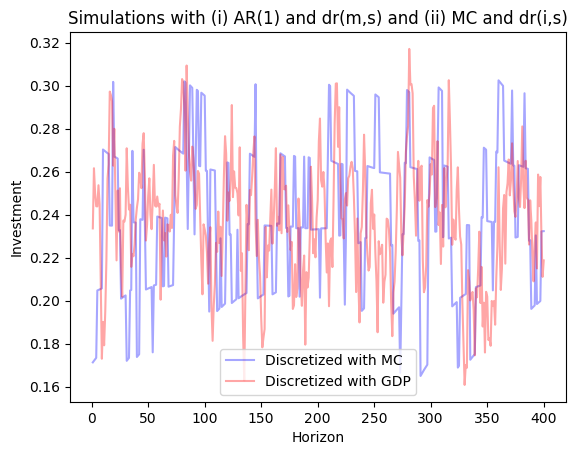

In [35]:
T=400

sim_ar = Dolo.simulate(model,dr_gdp; T=T)

sim_armc = Dolo.simulate(model, dr_mc, mc_ar; T=T)

plt.title("Simulations with (i) AR(1) and dr(m,s) and (ii) MC and dr(i,s)");
plt.xlabel("Horizon");
plt.ylabel("Investment");
hor = linspace(1, sim_armc[Axis{:T}][end], sim_armc[Axis{:T}][end])
plt.plot(hor, sim_armc[Axis{:N}(1), Axis{:V}(:i)], color="blue", alpha = .35, label = "Discretized with MC")
plt.plot(hor, sim_ar[Axis{:N}(1), Axis{:V}(:i)], color="red", alpha = .35, label = "Discretized with GDP")
plt.legend();

Note, another possibility to simulate a model with an AR(1) would be to discretize it's driving process with MC, obtain dr(i,s), interpolate the decision rule and use the initial AR(1) to simulate. To be done. 